<a href="https://colab.research.google.com/github/yaranasserr/Neural-Machine-Translation/blob/main/y_Neural_Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 using [PyTorch](https://pytorch.org/) to implement a sequence-to-sequence (seq2seq) transformer model to build a nerual machine translation (NMT) system, which translates from French to English.

In [2]:
# Pytorch is typically already installed in Google Colab (uncomment to install):
# !pip install torch==1.8.0
# or for GPU support:
# !pip install torch==1.8.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install transformers==4.27.0
!pip install datasets==2.10.0
# NLTK is typically also already installed in Google Colab (uncomment to install):
# !pip install nltk==3.8.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.0 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.2
    Uninstalling transformers-4.46.2:
      Successfully uninstalled transformers-4.46.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.27.0 which is incompatible.
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other require

## Download NMT data

We first download the data for NMT, which contains pairs of parallel sentences.

In [3]:
!wget --quiet https://princeton-nlp.github.io/cos484/assignments/a4/resources.zip
!unzip -qo resources.zip

## Data preprocessing
In this section we will write code to load and tokenize the data for NMT.


The parallel data is provided as huggingface datasets, one for each split of `train`, `validation` and `test`. We load it via the `load_from_disk` method and inspect its features. If you'd like to know more about these dataset objects, have a look at [this tutorial](https://huggingface.co/docs/datasets/access).

In [4]:
!ls /content/resources


parallel_en_fr_corpus  tokenizer_en  tokenizer_fr


In [5]:
from datasets import load_from_disk

raw_text_datasets = load_from_disk("file:///content/resources/parallel_en_fr_corpus")


print("Summary of splits:", raw_text_datasets)
print("First training example:", raw_text_datasets["train"][0])

Summary of splits: DatasetDict({
    train: Dataset({
        features: ['text_en', 'text_fr'],
        num_rows: 8701
    })
    validation: Dataset({
        features: ['text_en', 'text_fr'],
        num_rows: 485
    })
    test: Dataset({
        features: ['text_en', 'text_fr'],
        num_rows: 486
    })
})
First training example: {'text_en': 'i m tough .', 'text_fr': 'je suis dure .'}


You are also provided with two pre-trained tokenizers for the source and target languages respectively, which we can load with the hugginface transfomers library. [This tutorial](https://huggingface.co/docs/transformers/preprocessing#natural-language-processing) provides an introduction to using pre-trained tokenizers and the powerful `AutoTokenizer` class. The tokenizers are based on byte-pair encodings which break words into smaller units. This is aimed at reducing the sparsity of words, as subwords can be shared between different rare words. If you are interested in learning more, see the paper [Neural Machine Translation of Rare Words with Subword Units](https://www.aclweb.org/anthology/P16-1162.pdf).

In [6]:
from transformers import AutoTokenizer
source_tokenizer = AutoTokenizer.from_pretrained("resources/tokenizer_fr")
target_tokenizer = AutoTokenizer.from_pretrained("resources/tokenizer_en")

print("Vocab size of source language:", source_tokenizer.vocab_size)
print("Vocab size of target language:", target_tokenizer.vocab_size)

# As a demonstration, we will the following English sentence to tokens.
example_sentence = "we have an example"
tokenizer_output = target_tokenizer(example_sentence)
print("\n*** Example ***")
print("Example sentence:", example_sentence)
print("Tokenizer output:", tokenizer_output)

# We convert every token id to its associated string, but find the special character ▁ which indicates the beginning of a word.
# Note that very common words are represented by a single token, while others are split into subunits due to the small vocab size.
# Also note that †he tokenizer already adds special tokens to the beginning and end of the sentence.
decoded_sequence = [target_tokenizer.decode(token) for token in tokenizer_output["input_ids"]]
print("Tokens:", decoded_sequence)

# By replacing the special character ▁ with whitespace, we can reconstruct a legibile sentence,
# which differs from the original example by special tokens, includings <unk> tokens, and minor whitespace differences.
reconstructed = "".join(decoded_sequence).replace("▁", " ")
print("Reconstructed sentence", reconstructed)

Vocab size of source language: 3200
Vocab size of target language: 3200

*** Example ***
Example sentence: we have an example
Tokenizer output: {'input_ids': [1, 64, 324, 103, 266, 1490, 92, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
Tokens: ['<s>', '▁we', '▁have', '▁an', '▁ex', 'amp', 'le', '</s>']
Reconstructed sentence <s> we have an example</s>


We now want to convert the entire dataset to token ids.
Specifically, we want to use the tokenizers to create a dataset with
features "encoder_input_ids" and "decoder_input_ids", which both have type `List[int]`
and which will later be the inputs to our encoder-decoder model. We will implement this using the powerful `map` function. You can find its API reference [here](https://huggingface.co/docs/datasets/v2.10.0/en/package_reference/main_classes#datasets.Dataset.map).

In [7]:
print(raw_text_datasets["train"].column_names)


['text_en', 'text_fr']


In [8]:
from typing import Dict, List

def map_example(example: Dict[str, str]) -> Dict[str, List[int]]:
    # Tokenize the source and target text for an entry in the parallel dataset
    # and return a dictionary with the keys "encoder_input_ids" and "decoder_input_ids".

    # Use the correct column names 'text_fr' for source (French) and 'text_en' for target (English)
    encoder_input_ids = source_tokenizer(example["text_fr"], truncation=True, padding="max_length", max_length=128)["input_ids"]
    decoder_input_ids = target_tokenizer(example["text_en"], truncation=True, padding="max_length", max_length=128)["input_ids"]

    return {
        "encoder_input_ids": encoder_input_ids,
        "decoder_input_ids": decoder_input_ids
    }

# When map is applied to the DatasetDict object, it will apply `map_example` separately to each split.
tokenized_datasets = raw_text_datasets.map(map_example, batched=False)

# The `remove_columns` removes the existing text features from the new dataset, as they are no longer needed.
tokenized_datasets = tokenized_datasets.remove_columns(raw_text_datasets.column_names["train"])

# Sanity checks on the new dataset
assert set(tokenized_datasets.column_names["train"]) == {"decoder_input_ids", "encoder_input_ids"}
assert len(tokenized_datasets["train"]) == len(raw_text_datasets["train"])


Map:   0%|          | 0/8701 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

Map:   0%|          | 0/486 [00:00<?, ? examples/s]

## Transformer model for NMT

We will now implement a encoder-decoder transformer model.
We already provide code for the Feedforward Layers and Transformer Blocks, but you will have to implement the MultiHeadAttention and Embedding layer from scratch, as well as registering all the layers in the final EncoderDecoderModel. Pay attention to doc-strings and typing information to understand the context and purpose of each missing code block!

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
from typing import Optional, Dict, List, Tuple

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import Optional, Tuple

class MultiHeadAttention(nn.Module):
    def __init__(self,
                 hidden_size: int,
                 num_attention_heads: int,
                 is_causal_attention: bool = False,
                 is_cross_attention: bool = False):
        """
        Multi-head attention mechanism with optional causal and cross-attention.

        Args:
            hidden_size: The dimensionality of the input vectors.
            num_attention_heads: The number of attention heads.
            is_causal_attention: Whether to apply causal masking (self-attention).
            is_cross_attention: Whether to perform cross-attention (using encoder outputs for keys and values).
        """
        super(MultiHeadAttention, self).__init__()
        assert hidden_size % num_attention_heads == 0, "The hidden size must be divisible by the number of attention heads."

        self.hidden_size = hidden_size
        self.num_attention_heads = num_attention_heads
        self.head_dim = hidden_size // num_attention_heads

        self.is_causal_attention = is_causal_attention
        self.is_cross_attention = is_cross_attention

        # Define projection layers for queries, keys, and values
        self.query_projection = nn.Linear(hidden_size, hidden_size)
        self.key_projection = nn.Linear(hidden_size, hidden_size)
        self.value_projection = nn.Linear(hidden_size, hidden_size)

        # Output projection layer
        self.output_projection = nn.Linear(hidden_size, hidden_size)

    def causal_attention_mask(self, sequence_length: int, device: Optional[torch.device] = None) -> torch.FloatTensor:
        """
        Generate a causal attention mask for self-attention.

        Args:
            sequence_length: The length of the sequence to generate a mask for.
            device: The device to store the mask on (optional).

        Returns:
            A mask tensor of shape (1, 1, sequence_length, sequence_length) with negative values above the diagonal.
        """
        mask = torch.triu(torch.ones(sequence_length, sequence_length), diagonal=1)
        mask = mask.float().masked_fill(mask == 1, float('-inf'))  # Set the upper triangle to -inf
        return mask.unsqueeze(0).unsqueeze(0).to(device)

    def forward(self,
                hidden_states: torch.FloatTensor,
                key_padding_mask: torch.BoolTensor,
                encoder_outputs: Optional[torch.FloatTensor] = None) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        """
        Perform scaled dot-product attention.

        Args:
            hidden_states: Input tensor of shape (batch_size, sequence_length, hidden_size).
            key_padding_mask: Mask to ignore padding tokens during attention.
            encoder_outputs: Optional tensor of shape (batch_size, encoder_sequence_length, hidden_size),
                              used in cross-attention.

        Returns:
            A tuple (output, attention_weights) where:
            - output: Attention output of shape (batch_size, sequence_length, hidden_size).
            - attention_weights: Normalized attention weights.
        """
        batch_size, seq_len, _ = hidden_states.size()

        # Project the input hidden states to query, key, and value
        queries = self.query_projection(hidden_states)  # (batch_size, seq_len, hidden_size)
        keys = self.key_projection(encoder_outputs if self.is_cross_attention else hidden_states)  # (batch_size, seq_len, hidden_size)
        values = self.value_projection(encoder_outputs if self.is_cross_attention else hidden_states)  # (batch_size, seq_len, hidden_size)

        # Reshape to (batch_size, num_heads, seq_len, head_dim)
        queries = queries.view(batch_size, seq_len, self.num_attention_heads, self.head_dim).transpose(1, 2)

        # For cross-attention, keys and values come from encoder outputs
        if self.is_cross_attention:
            encoder_seq_len = encoder_outputs.size(1)
            keys = keys.view(batch_size, encoder_seq_len, self.num_attention_heads, self.head_dim).transpose(1, 2)
            values = values.view(batch_size, encoder_seq_len, self.num_attention_heads, self.head_dim).transpose(1, 2)
        else:
            keys = keys.view(batch_size, seq_len, self.num_attention_heads, self.head_dim).transpose(1, 2)
            values = values.view(batch_size, seq_len, self.num_attention_heads, self.head_dim).transpose(1, 2)

        # Compute attention scores: (batch_size, num_heads, seq_len, seq_len)
        attention_scores = torch.matmul(queries, keys.transpose(-1, -2))  # (batch_size, num_heads, seq_len, seq_len)
        attention_scores = attention_scores / math.sqrt(self.head_dim)

        # Apply causal mask if necessary
        if self.is_causal_attention:
            mask = self.causal_attention_mask(seq_len, hidden_states.device)
            attention_scores += mask

        # Apply padding mask if necessary
        attention_scores = attention_scores.masked_fill(key_padding_mask.unsqueeze(1).unsqueeze(2), float('-inf'))

        # Normalize attention scores
        attention_weights = F.softmax(attention_scores, dim=-1)  # (batch_size, num_heads, seq_len, seq_len)

        # Compute the weighted sum of the values: (batch_size, num_heads, seq_len, head_dim)
        attention_output = torch.matmul(attention_weights, values)  # (batch_size, num_heads, seq_len, head_dim)

        # Reshape the output back to (batch_size, seq_len, hidden_size)
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.hidden_size)

        # Apply the output projection
        output = self.output_projection(attention_output)

        return output, attention_weights


Before we move on to the other modules, you should implement a sanity check for your attention implementation:
1. We check the dimensions of the output of the layer and
2. We plot the attention weights to some toy embedding inputs.
We assume that the last token in the encoder and the last two tokens in the decoder are pad tokens.

In [11]:
embed_dim = 8
num_heads = 2
batch_size = 1
encoder_seq_length = 5
decoder_seq_length = 7

encoder_outputs = torch.randn(batch_size, encoder_seq_length, embed_dim)
decoder_inputs = torch.randn(batch_size, decoder_seq_length, embed_dim)

encoder_padding_mask = torch.zeros(batch_size, encoder_seq_length, dtype=torch.bool)
encoder_padding_mask[:, -1] = True # The last encoder token is a padding tokens

decoder_padding_mask = torch.zeros(batch_size, decoder_seq_length, dtype=torch.bool)
decoder_padding_mask[:, -2:] = True # The last two decoder tokens are padding token


cross_attention = MultiHeadAttention(embed_dim, num_heads, is_cross_attention=True)
causal_attention = MultiHeadAttention(embed_dim, num_heads, is_causal_attention=True)

cross_attention_out, cross_attention_weights = cross_attention(decoder_inputs, encoder_padding_mask, encoder_outputs)
causal_attention_out, causal_attention_weights = causal_attention(decoder_inputs, decoder_padding_mask)

# Make sure your outputs have the right hapes
assert cross_attention_out.shape == (batch_size, decoder_seq_length, embed_dim)
assert cross_attention_weights.shape == (batch_size, num_heads, decoder_seq_length, encoder_seq_length)
assert causal_attention_out.shape == (batch_size, decoder_seq_length, embed_dim)
assert causal_attention_weights.shape == (batch_size, num_heads, decoder_seq_length, decoder_seq_length)

# Check that the attention weights are normalized
assert torch.isclose(cross_attention_weights.sum(dim=-1), torch.tensor(1.0)).all()
assert torch.isclose(causal_attention_weights.sum(dim=-1), torch.tensor(1.0)).all()

# Check if the attention masking works
assert torch.isclose(cross_attention_weights[:,:,:,-1], torch.tensor(0.0)).all()
assert torch.isclose(causal_attention_weights[:,:,:,-2:], torch.tensor(0.0)).all()
assert torch.isclose(causal_attention_weights[:,:,2,3:], torch.tensor(0.0)).all()




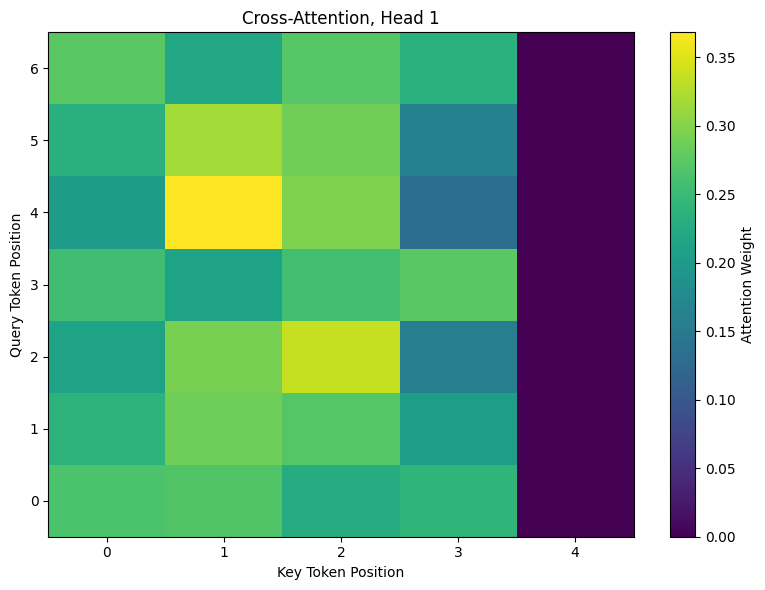

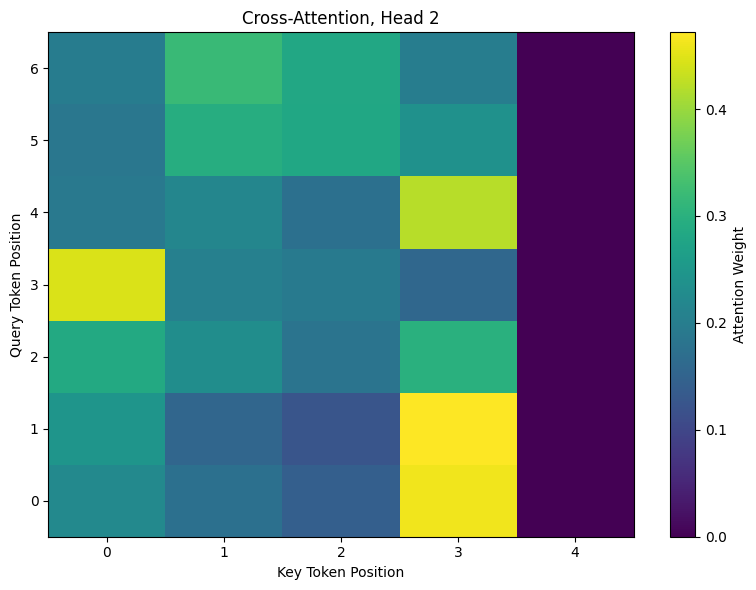

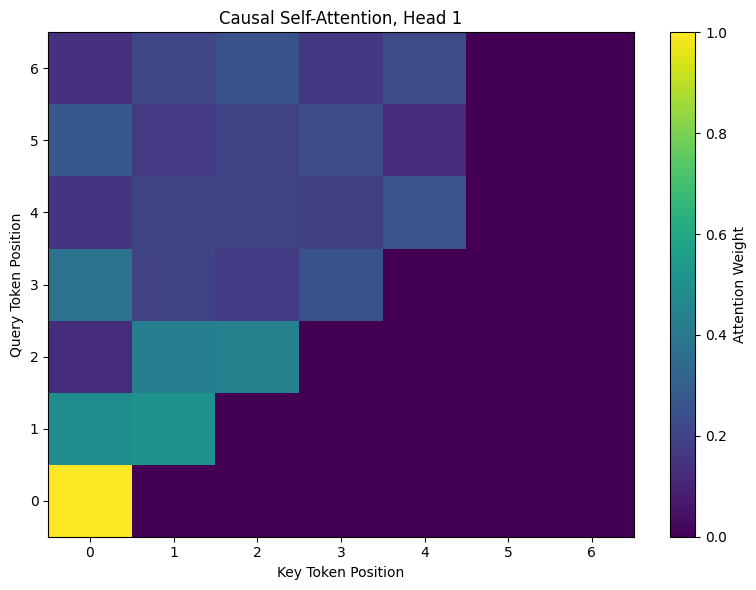

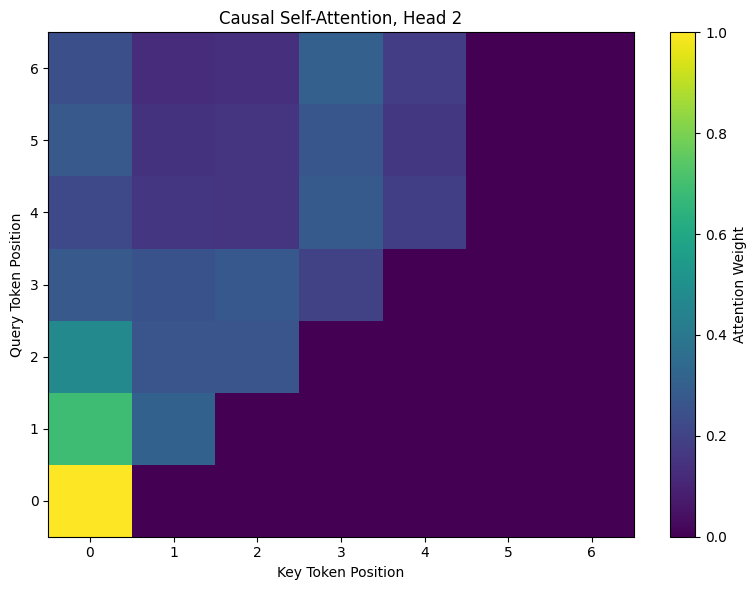

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_attention_matrix(attention_matrix, title):
    """Creates a new figure and plots the normalized attention weights as a heatmap.

    Args:
        attention_matrix: A numpy array of shape (number_of_query_tokens, number_of_key_tokens)
        title: The title of the plot.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(attention_matrix, cmap='viridis', aspect='auto', origin='lower')
    plt.colorbar(label='Attention Weight')
    plt.title(title)
    plt.xlabel("Key Token Position")
    plt.ylabel("Query Token Position")
    plt.tight_layout()
    plt.show()

# Assuming `cross_attention_weights` and `causal_attention_weights` are 4D tensors
# with the shape (batch_size, num_heads, sequence_length, sequence_length)
# We plot the attention weights for each attention head.
plot_attention_matrix(cross_attention_weights[0,0].detach().numpy(), "Cross-Attention, Head 1")
plot_attention_matrix(cross_attention_weights[0,1].detach().numpy(), "Cross-Attention, Head 2")
plot_attention_matrix(causal_attention_weights[0,0].detach().numpy(), "Causal Self-Attention, Head 1")
plot_attention_matrix(causal_attention_weights[0,1].detach().numpy(), "Causal Self-Attention, Head 2")


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerEmbeddings(nn.Module):
    def __init__(self, vocab_size: int, hidden_size: int, max_sequence_length: int):
        """Defines the embedding layer with learnt positional embeddings.

        This layer defines both the token embeddings and positional embeddings,
        which are added together to form the final embedding.

        Args:
            vocab_size: The size of the vocabulary,
                        used to define the size of the token embedding table.
            hidden_size: The dimensionality of the embedding space for both token embeddings and positional embeddings.
            max_sequence_length: The maximum sequence length of the input sequences,
                        used to define the size of the position embedding table.

        Note that this implementation does not use dropout on the embeddings
        and uses learnt positional embeddings instead of sinusoidal embeddings.
        """
        super().__init__()

        # Token embedding layer
        self.token_embeddings = nn.Embedding(vocab_size, hidden_size)

        # Positional embedding layer
        self.position_embeddings = nn.Embedding(max_sequence_length, hidden_size)

    def compute_logits(self, decoder_output: torch.FloatTensor) -> torch.FloatTensor:
        """Computes the logits for the next token prediction given the decoder output.

        Args:
            decoder_output: Tensor of shape (batch_size, sequence_length, hidden_size) - the output of the decoder.

        Returns:
            Tensor of shape (batch_size, sequence_length, vocab_size) containing the logits for the next token prediction.
        """
        # We can compute the logits by projecting the decoder output to the vocabulary size
        logits = torch.matmul(decoder_output, self.token_embeddings.weight.T)
        return logits

    def forward(self, input_ids: torch.LongTensor) -> torch.FloatTensor:
        """Computes the embeddings for the input tokens.

        Args:
            input_ids: Tensor of shape (batch_size, sequence_length) containing the input token ids.

        Returns:
            Tensor of shape (batch_size, sequence_length, hidden_size) containing
                    the sum of token embeddings and position embeddings for the input tokens.
        """
        # Get token embeddings
        token_embeds = self.token_embeddings(input_ids)  # (batch_size, sequence_length, hidden_size)

        # Generate position indices (0, 1, 2, ..., seq_len-1)
        batch_size, seq_len = input_ids.size()
        position_indices = torch.arange(seq_len, device=input_ids.device).unsqueeze(0).expand(batch_size, seq_len)

        # Get positional embeddings
        position_embeds = self.position_embeddings(position_indices)  # (batch_size, sequence_length, hidden_size)

        # Sum the token embeddings and position embeddings
        embeddings = token_embeds + position_embeds

        return embeddings


In [14]:
class TransformerBlock(nn.Module):
    def __init__(self,
                 hidden_size: int,
                 intermediate_size: int,
                 num_attention_heads: int,
                 hidden_dropout_prob: float,
                 is_decoder: bool = False):
        """Defines a single Transformer block, which can be either for the encoder or the decoder.

        Args:
            hidden_size: The dimensionality of the input and output vectors of this layer.
            intermediate_size: The intermediate size of the feedforward layers.
            num_attention_heads: The number of attention heads.
            hidden_dropout_prob: The dropout probability for the hidden states.
            is_decoder: Whether this block is part of the decoder.
        """
        super().__init__()

        self.is_decoder = is_decoder
        self.self_attention = MultiHeadAttention(hidden_size, num_attention_heads, is_causal_attention=is_decoder)
        self.self_attention_layer_norm = nn.LayerNorm(hidden_size)

        if is_decoder:
            self.cross_attention = MultiHeadAttention(hidden_size, num_attention_heads, is_cross_attention=True)
            self.cross_attention_layer_norm = nn.LayerNorm(hidden_size)

        self.feedforward = nn.Sequential(
            nn.Linear(hidden_size, intermediate_size),
            nn.ReLU(),
            nn.Linear(intermediate_size, hidden_size),
            nn.Dropout(hidden_dropout_prob))
        self.feedforward_layer_norm = nn.LayerNorm(hidden_size)

    def forward(self,
                hidden_states: torch.FloatTensor,
                padding_mask: torch.BoolTensor,
                encoder_outputs: Optional[torch.FloatTensor] = None,
                encoder_padding_mask: Optional[torch.BoolTensor] = None) -> torch.FloatTensor:
        """Defines a single Transformer block, either for the encoder or the decoder.

        Args:
            hidden_states: Tensor of shape (batch_size, sequence_length, hidden_size) - the outputs from the previous layer.
            padding_mask: Tensor of shape (batch_size, sequence_length) indicating which tokens are padding tokens.
                    A `True` entry means that this token should be ignored for the purpose of attention.
            encoder_outputs: Optional tensor of shape (batch_size, encoder_sequence_length, hidden_size),
                    which are the output vectors of the encoder. This argument is only used by decoder blocks.
            encoder_padding_mask: Optional tensor of shape (batch_size, encoder_sequence_length) indicating
                    which encoder tokens are padding tokens. This argument is only used in decoder blocks.
                    A `True` entry means that this token should be ignored for the purpose of attention.

        """
        hidden_states = self.self_attention(hidden_states, padding_mask)[0] + hidden_states
        hidden_states = self.self_attention_layer_norm(hidden_states)

        if self.is_decoder:
            hidden_states = self.cross_attention(hidden_states, encoder_padding_mask, encoder_outputs)[0] + hidden_states
            hidden_states = self.cross_attention_layer_norm(hidden_states)

        hidden_states = self.feedforward(hidden_states) + hidden_states
        hidden_states = self.feedforward_layer_norm(hidden_states)
        return hidden_states

In [15]:
import torch
import torch.nn as nn

class EncoderDecoderModel(nn.Module):
    def __init__(self,
                 source_vocab_size: int,
                 target_vocab_size: int,
                 hidden_size: int,
                 intermediate_size: int,
                 num_attention_heads: int,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 max_sequence_length: int,
                 hidden_dropout_prob: float):
        """A encoder-decoder transformer model which can be used for NMT.

        Args:
            source_vocab_size: The size of the source vocabulary.
            target_vocab_size: The size of the target vocabulary.
            hidden_size: The dimensionality of all input and output embeddings.
            intermediate_size: The intermediate size in the feedforward layers.
            num_attention_heads: The number of attention heads in each multi-head attention modules.
            num_encoder_layers: The number of transformer blocks in the encoder.
            num_decoder_layers: The number of transformer blocks in the decoder.
            max_sequence_length: The maximum sequence length that this model can handle.
            hidden_dropout_prob: The dropout probability in the hidden state in each block.
        """

        super().__init__()

        # Embeddings for both source and target vocabularies
        self.source_embeddings = TransformerEmbeddings(source_vocab_size, hidden_size, max_sequence_length)
        self.target_embeddings = TransformerEmbeddings(target_vocab_size, hidden_size, max_sequence_length)

        # Encoder layers: A list of transformer blocks
        self.encoder_blocks = nn.ModuleList([
            TransformerBlock(hidden_size, intermediate_size, num_attention_heads, hidden_dropout_prob)
            for _ in range(num_encoder_layers)
        ])

        # Decoder layers: A list of transformer blocks
        self.decoder_blocks = nn.ModuleList([
            TransformerBlock(hidden_size, intermediate_size, num_attention_heads, hidden_dropout_prob)
            for _ in range(num_decoder_layers)
        ])

        # Output projection layer
        self.output_layer = nn.Linear(hidden_size, target_vocab_size)

    def forward_encoder(self, input_ids: torch.LongTensor, padding_mask: torch.BoolTensor) -> torch.FloatTensor:
        """Implement the forward pass of the encoder.

        Args:
            input_ids: tensor of shape (batch_size, sequence_length) containing the input token ids to the encoder.
            padding_mask: tensor of shape (batch_size, sequence_length) indicating which encoder tokens are padding tokens (`True`)
                    and should be ignored in self-attention computations.

        Returns:
            Tensor of shape (batch_size, sequence_length, hidden_size) containing the output embeddings of the encoder.
        """

        # Get the input embeddings
        encoder_inputs = self.source_embeddings(input_ids)

        # Pass through each encoder block
        for encoder_block in self.encoder_blocks:
            encoder_inputs = encoder_block(encoder_inputs, padding_mask)

        return encoder_inputs

    def forward_decoder(self,
                        input_ids: torch.LongTensor,
                        padding_mask: torch.BoolTensor,
                        encoder_outputs: torch.FloatTensor,
                        encoder_padding_mask: torch.BoolTensor) -> torch.FloatTensor:
        """Implement the forward pass of the decoder.

        Args:
            input_ids: Tensor of shape (batch_size, sequence_length) containing the input token ids to the decoder.
            padding_mask: Tensor of shape (batch_size, sequence_length) indicating which decoder tokens are padding tokens (`True`)
                    and should be ignored in self-attention computations.
            encoder_outputs: Tensor of shape (batch_size, encoder_sequence_length, hidden_size) containing the output embeddings of the encoder.
            encoder_padding_mask: Tensor of shape (batch_size, encoder_sequence_length) indicating which encoder tokens are padding tokens (`True`)
                    and should be ignored in cross-attention computations.

        Returns:
            Tensor of shape (batch_size, sequence_length, target_vocabulary_size)
            containing the logits for predicting the next token in the target sequence.
        """

        # Get the input embeddings for the decoder
        decoder_inputs = self.target_embeddings(input_ids)

        # Pass through each decoder block
        for decoder_block in self.decoder_blocks:
            decoder_inputs = decoder_block(decoder_inputs, padding_mask, encoder_outputs, encoder_padding_mask)

        # Project the decoder output to vocabulary size
        logits = self.output_layer(decoder_inputs)

        return logits

    def forward(self, encoder_input_ids, encoder_padding_mask, decoder_input_ids, decoder_padding_mask):
        # Forward pass through encoder
        encoder_outputs = self.forward_encoder(encoder_input_ids, encoder_padding_mask)

        # Forward pass through decoder
        decoder_logits = self.forward_decoder(decoder_input_ids, decoder_padding_mask, encoder_outputs, encoder_padding_mask)

        return decoder_logits


## Train the model

In this section, we train the seq2seq model on the parallel tokenized corpus.
Before you start training models, you should implement and test the model and its sub-modules, especially the attention.

First, we implement a `collate` function, which takes a list of examples from the dataset and forms a batch,
consisting of padded encoder and decoder input ids, as well as encoder and decoder padding masks.

In [16]:
def collate_fn(examples: List[Dict[str, List[int]]]) -> Dict[str, torch.Tensor]:
    """Collates a list of variable length sequences from the dataset into a batch of pytorch tensors with padding."""

    encoder_sequence_length = max(len(example["encoder_input_ids"]) for example in examples)
    decoder_sequence_length = max(len(example["decoder_input_ids"]) for example in examples)
    batch_size = len(examples)

    encoder_input_ids = torch.full((batch_size, encoder_sequence_length),
                                   fill_value=source_tokenizer.pad_token_id,
                                   dtype=torch.int64)
    encoder_padding_mask = torch.ones((batch_size, encoder_sequence_length),
                                      dtype=torch.bool)

    decoder_input_ids = torch.full((batch_size, decoder_sequence_length),
                                   fill_value=target_tokenizer.pad_token_id,
                                   dtype=torch.int64)
    decoder_padding_mask = torch.ones((batch_size, decoder_sequence_length),
                                      dtype=torch.bool)

    for i, example in enumerate(examples):
        encoder_input_ids[i, :len(example["encoder_input_ids"])] = torch.tensor(example["encoder_input_ids"])
        encoder_padding_mask[i, :len(example["encoder_input_ids"])] = False

        decoder_input_ids[i, :len(example["decoder_input_ids"])] = torch.tensor(example["decoder_input_ids"])
        decoder_padding_mask[i, :len(example["decoder_input_ids"])] = False

    return {"encoder_input_ids": encoder_input_ids,
            "encoder_padding_mask": encoder_padding_mask,
            "decoder_input_ids": decoder_input_ids,
            "decoder_padding_mask": decoder_padding_mask}

Next, we provide a simple training loop.

In [17]:
import torch

# Convert the lists to tensors and then find the maximum token ID
encoder_input_ids_tensor = torch.tensor(tokenized_datasets["train"]["encoder_input_ids"])
decoder_input_ids_tensor = torch.tensor(tokenized_datasets["train"]["decoder_input_ids"])

# Check the maximum token IDs
print("Max encoder token ID in training data:", encoder_input_ids_tensor.max().item())
print("Max decoder token ID in training data:", decoder_input_ids_tensor.max().item())


Max encoder token ID in training data: 3199
Max decoder token ID in training data: 3199


In [30]:
import time
import math

def compute_loss_per_token(model, batch):
    logits = model(**batch)

    valid_label_mask = ~(batch["decoder_padding_mask"][:,1:])
    labels = batch["decoder_input_ids"][:,1:][valid_label_mask]
    logits = logits[:,:-1][valid_label_mask]

    return F.cross_entropy(logits, labels, reduction='none')


def evaluate_perplexity(model, dataset, batch_size=32, device="cpu"):
    model.eval()

    dev_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    num_tokens = loss_sum = 0

    # no_grad() signals backend to throw away all gradients
    with torch.no_grad():
        for batch in dev_loader:
            # Move tensors in batch to device
            for key in batch:
                batch[key] = batch[key].to(device)

            token_losses = compute_loss_per_token(model, batch)

            loss_sum += token_losses.sum()
            num_tokens += token_losses.numel()

        dev_ppl = (loss_sum / num_tokens).exp().cpu().item()
    return dev_ppl


def train(model, training_dataset, validation_dataset,
          batch_size=32, lr=1e-3, max_epoch=10, log_every=10, valid_niter=100,
          model_path="model.pt"):
    model.train()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('Use device: %s' % device)

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    epoch = global_step = loss_sum = num_tokens = num_examples = 0
    best_valid_perplexity = float('inf')
    train_time = begin_time = time.time()
    print('Beginning maximum likelihood training')


    while True:
        train_loader = torch.utils.data.DataLoader(
            training_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        epoch += 1
        batches_per_epoch = len(train_loader)
        for i, batch in enumerate(train_loader):
            global_step += 1

            # Move tensors in batch to device
            for key in batch:
                batch[key] = batch[key].to(device)

            optimizer.zero_grad()

            token_losses = compute_loss_per_token(model, batch)
            total_loss = token_losses.sum()

            loss = total_loss / batch_size
            loss.backward()

            optimizer.step()

            loss_sum += total_loss.cpu().item()
            num_tokens += token_losses.numel()
            num_examples += batch_size

            if global_step % log_every == 0:
                average_loss = loss_sum / num_examples
                average_ppl = math.exp(loss_sum / num_tokens)
                print(f"epoch {epoch} ({i}/{batches_per_epoch}) | step {global_step} | "
                      f"avg_nll={average_loss:.2f} avg_ppl={average_ppl:.2f} "
                      f"speed={num_tokens / (time.time() - train_time):.2f} words/sec "
                      f"time_elapsed={time.time() - begin_time:.2f} sec")

                train_time = time.time()
                loss_sum = num_tokens = num_examples = 0.0

            if global_step % valid_niter == 0:
                print('Begin validation ...')
                dev_perplexity = evaluate_perplexity(model, validation_dataset, batch_size=batch_size, device=device)

                print(f"validation: step {global_step} | dev_ppl={dev_perplexity}")

                if dev_perplexity < best_valid_perplexity:
                    best_valid_perplexity = dev_perplexity
                    print(f"epoch {epoch} step {global_step}: save currently the best model to '{model_path}'")
                    torch.save(model.state_dict(), model_path)
                    torch.save(optimizer.state_dict(), model_path + '.optim')
                model.train()

        if epoch == max_epoch:
            print('Reached maximum number of epochs')
            break

Let's train a relatively small model architecture for 15 epochs.
With a reasonable implementation, this should take about 16 minutes on CPU / 3 minutes on GPU and we should achieve a validation perplexity of below 10!

In [29]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [24]:
print(f"Source vocab size: {source_tokenizer.vocab_size}")
print(f"Target vocab size: {target_tokenizer.vocab_size}")


Source vocab size: 3200
Target vocab size: 3200


In [31]:
# Set a random seed, so you obtain the same output model if you run this cell again.
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

model = EncoderDecoderModel(
    source_vocab_size=source_tokenizer.vocab_size,
    target_vocab_size=target_tokenizer.vocab_size,
    hidden_size=32,
    intermediate_size=32 * 4,
    num_attention_heads=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    max_sequence_length=32,
    hidden_dropout_prob=0.1,
    )

print("Model architecture:", model)
print("Total number of trainable model parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

train(model, tokenized_datasets["train"], tokenized_datasets["validation"],
      max_epoch=15, model_path="model.pt")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Evaluate the model

We have trained a seq2seq model for the NMT task. Now let's evaluate the model on the test set by generating translations with beam search and comparing them to the gold translations using the BLEU score.

In [19]:
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu

def beam_search(model: EncoderDecoderModel,
                encoder_input_ids: torch.LongTensor,
                beam_width: int = 5,
                max_len: int = 32) -> Tuple[torch.LongTensor, float]:
    """Run beam search on the encoder-decoder model for a single source sequence.

    Args:
        model: The encoder-decoder model.
        encoder_input_ids: The input sequence. Tensor of shape [encoder_sequence_length].
        beam_width: Number of generations to expand at each time step.
        max_len: Stop generation when reaching this length for the generated sequence.

    Returns:
        A tuple (generation, score) where generation is the generated target sequence and
            a tensor of shape [target_sequence_length] and score is the corresponding
            log-probability of this generation.
    """
    model.eval()

    encoder_input_ids = encoder_input_ids.unsqueeze(0) # Add the batch dimension
    encoder_padding_mask = torch.zeros_like(encoder_input_ids, dtype=torch.bool) # No padding
    encoder_outputs = model.forward_encoder(encoder_input_ids, encoder_padding_mask)

    generations = [torch.tensor([target_tokenizer.bos_token_id], device=encoder_input_ids.device)]
    scores = [0.0]

    best_generation = None
    best_score = float('-inf')

    for _ in range(max_len):
        new_generations = []
        new_scores = []
        for score, generation in zip(scores, generations):
            generation = generation.unsqueeze(0) # Add the batch dimension
            padding_mask = torch.zeros_like(generation, dtype=torch.bool) # No padding
            decoder_output = model.forward_decoder(generation, padding_mask, encoder_outputs, encoder_padding_mask)
            last_log_probs = decoder_output[0, -1, :].log_softmax(dim=-1)
            top_log_probs, top_indices = last_log_probs.topk(beam_width, dim=-1)

            new_generations.append(torch.cat([generation.expand(beam_width, -1), top_indices[:,None]], dim=1))
            new_scores.append(score + top_log_probs)

        new_generations = torch.cat(new_generations, dim=0)
        new_scores = torch.cat(new_scores, dim=0)

        ends_with_eos = target_tokenizer.eos_token_id == new_generations[:,-1]

        if ends_with_eos.any():
            new_completed_generations = new_generations[ends_with_eos]
            new_completed_scores = new_scores[ends_with_eos]

            if new_completed_scores.max() > best_score:
                best_score = new_completed_scores.max()
                best_generation = new_completed_generations[new_completed_scores.argmax()]

        if best_score >= new_scores.max():
            break

        scores, indices = torch.topk(new_scores, beam_width, dim=-1)
        generations = new_generations[indices]

    if best_generation is None:
        best_generation = generations[0]
        best_score = scores[0]

    return best_generation, best_score.cpu().item()


def run_generation(model, test_dataset, beam_size=5, max_decoding_time_step=32):
    """Run beam search decoding on the test set, compute BLEU and return reference and candidate target sentences.
    """

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Use device: %s' % device)

    input_sentences = []
    reference_sentences = []
    candidate_sentences = []

    with torch.no_grad():
        for example in tqdm(test_dataset):
            encoder_input_ids = torch.tensor(example["encoder_input_ids"], device=device)

            generation, _ = beam_search(model, encoder_input_ids, beam_size, max_decoding_time_step)

            # Decode given source sequence and generated target sequence and avoid special tokens

            input_text = "".join(source_tokenizer.decode(token).replace("▁", " ") for token in example["encoder_input_ids"][1:-1])
            reference_text = "".join(target_tokenizer.decode(token).replace("▁", " ") for token in example["decoder_input_ids"][1:-1])
            candidate_text = "".join(target_tokenizer.decode(token).replace("▁", " ") for token in generation[1:-1].cpu())

            reference_sentences.append(reference_text)
            candidate_sentences.append(candidate_text)
            input_sentences.append(input_text)


    bleu_score = corpus_bleu([[ref] for ref in reference_sentences],
                             [candidate for candidate in candidate_sentences])

    return bleu_score, input_sentences, reference_sentences, candidate_sentences

In [20]:
# Restore the best validation checkpoint
model.load_state_dict(torch.load("model.pt"))

bleu_score, inputs, references, candidates = run_generation(model, tokenized_datasets["test"])
print('\n\nCorpus BLEU: {}'.format(bleu_score * 100))

NameError: name 'model' is not defined

Let's look at some examples. What do you think of the quality of the translations?

In [ ]:
# Feel free to change the range to look at more samples!
for k in range(10, 20):
  print(f"===== Sample {k} =====")
  print(f"Input: {inputs[k]}")
  print(f"Gold: {references[k]}")
  print(f"Pred: {candidates[k]}")